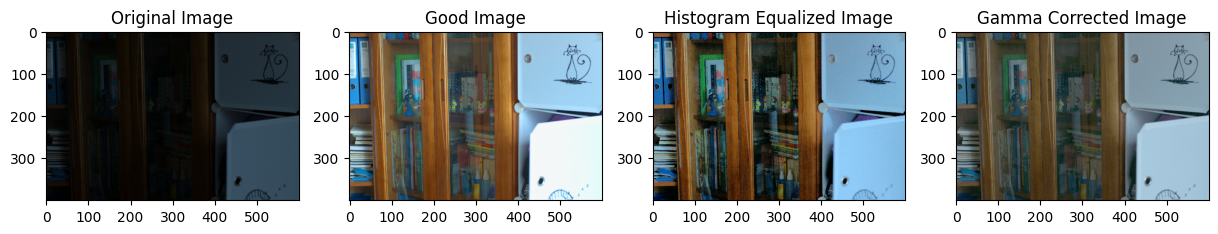

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ReLU, UpSampling2D
from keras.preprocessing import image
# 1. Histogram Equalization
def histogram_equalization(img):
    # Convert the image to HSV (Hue, Saturation, Value)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply histogram equalization to the V (Value) channel (intensity)
    hsv_img[..., 2] = cv2.equalizeHist(hsv_img[..., 2])

    # Convert back to BGR color space
    eq_color_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

    return eq_color_img

# 2. Gamma Correction
def gamma_correction(img, gamma):
    # Apply gamma correction
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(img, table)
    return gamma_corrected

def increase_contrast(img, factor=2):
    # Convert the image to float32 to avoid clipping
    img_float = img.astype(np.float32)

    # Increase the contrast by multiplying the pixel values by a factor
    img_float = img_float * factor

    # Clip the values to be within the valid range [0, 255]
    img_float = np.clip(img_float, 0, 255)

    # Convert back to uint8
    contrast_img = img_float.astype(np.uint8)

    return contrast_img

# Load your low-light image
good_img = cv2.imread('goodImage.png')  # Replace with the path to your image
ori_img = cv2.imread('lowLightImage.png')  # Replace with the path to your image

# #image with high conrast
high_contrast_img = increase_contrast(ori_img)

# Apply Histogram Equalization
hist_eq_img = histogram_equalization(ori_img)

# Apply Gamma Correction
gamma_img = gamma_correction(high_contrast_img, gamma=2)  # You can change the gamma value for desired brightness

# Show the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(good_img, cv2.COLOR_BGR2RGB))
plt.title("Good Image")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(hist_eq_img, cv2.COLOR_BGR2RGB))
plt.title("Histogram Equalized Image")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(gamma_img, cv2.COLOR_BGR2RGB))
plt.title("Gamma Corrected Image")

plt.show()





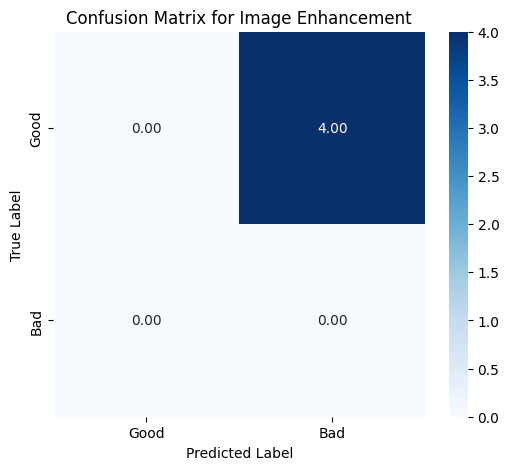

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Enhanced images
hist_eq_img = histogram_equalization(ori_img)
gamma_img = gamma_correction(ori_img, gamma=2)
high_contrast_img = increase_contrast(ori_img)

# Function to compute SSIM
def calculate_ssim(ref, img):
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return ssim(ref_gray, img_gray)

# Function to compute PSNR
def calculate_psnr(ref, img):
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Classify based on SSIM and PSNR thresholds
def classify_image(ref, img):
    ssim_score = calculate_ssim(ref, img)
    psnr_score = calculate_psnr(ref, img)
    if ssim_score > 0.85 and psnr_score > 30:
        return "Good"
    else:
        return "Bad"

# Generate labels
true_labels = ["Good", "Good", "Good", "Good"]
pred_labels = [
    classify_image(good_img, ori_img),
    classify_image(good_img, hist_eq_img),
    classify_image(good_img, gamma_img),
    classify_image(good_img, high_contrast_img)
]

# Compute confusion matrix
labels = ["Good", "Bad"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Image Enhancement")
plt.show()


In [7]:
import cv2
import numpy as np

def calculate_psnr(original, enhanced):
    # Resize images to the same shape (e.g., 256x256 or 512x512)
    size = (256, 256)  # You can change the size to any desired resolution
    original_resized = cv2.resize(original, size)
    enhanced_resized = cv2.resize(enhanced, size)

    mse = np.mean((original_resized - enhanced_resized) ** 2)
    if mse == 0:
        return 100  # No noise, perfect similarity

    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

# Example of how to call the function:
psnr_value = calculate_psnr(good_img, hist_eq_img)
print(f"PSNR: {psnr_value} dB")


PSNR: 28.1241586930759 dB


In [21]:
import numpy as np
import cv2

def calculate_confusion_matrix(ground_truth, enhanced, threshold=10):
    """
    Calculate the confusion matrix for an enhanced image compared to the ground truth image.

    Args:
        ground_truth (np.array): The "good image" (reference image) in BGR format.
        enhanced (np.array): The enhanced image in BGR format.
        threshold (int): The tolerance for pixel intensity differences.

    Returns:
        dict: Confusion matrix containing TP, FP, TN, FN counts.
    """
    # Resize images to ensure they have the same dimensions
    ground_truth = cv2.resize(ground_truth, (256, 256))
    enhanced = cv2.resize(enhanced, (256, 256))

    # Convert images to grayscale for intensity comparison
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Initialize confusion matrix components
    TP = FP = TN = FN = 0

    # Compare pixel intensities
    for gt_pixel, en_pixel in zip(ground_truth_gray.flatten(), enhanced_gray.flatten()):
        diff = abs(gt_pixel - en_pixel)
        if diff <= threshold:  # Within acceptable range, considered a match
            if en_pixel == gt_pixel:  # No enhancement needed
                TN += 1
            else:  # Enhanced correctly
                TP += 1
        else:
            if en_pixel > gt_pixel:  # Over-enhanced
                FP += 1
            else:  # Under-enhanced
                FN += 1

    # Create the confusion matrix
    confusion_matrix = {
        "True Positive": TP,
        "False Positive": FP,
        "True Negative": TN,
        "False Negative": FN
    }

    return confusion_matrix


# Load the images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Apply the enhancement methods
hist_eq_img = histogram_equalization(ori_img)
gamma_img = gamma_correction(ori_img, gamma=2)
high_contrast_img = increase_contrast(ori_img)

# Calculate confusion matrices
hist_eq_conf_matrix = calculate_confusion_matrix(good_img, hist_eq_img)
gamma_conf_matrix = calculate_confusion_matrix(good_img, gamma_img)
contrast_conf_matrix = calculate_confusion_matrix(good_img, high_contrast_img)

# Print the results
print("Confusion Matrix for Histogram Equalization:")
print(hist_eq_conf_matrix)

print("\nConfusion Matrix for Gamma Correction:")
print(gamma_conf_matrix)

print("\nConfusion Matrix for Contrast Enhancement:")
print(contrast_conf_matrix)


<ipython-input-21-3f3056306012>:29: RuntimeWarning: overflow encountered in scalar subtract
  diff = abs(gt_pixel - en_pixel)


Confusion Matrix for Histogram Equalization:
{'True Positive': 9645, 'False Positive': 39672, 'True Negative': 1311, 'False Negative': 14908}

Confusion Matrix for Gamma Correction:
{'True Positive': 173, 'False Positive': 4, 'True Negative': 1, 'False Negative': 65358}

Confusion Matrix for Contrast Enhancement:
{'True Positive': 1, 'False Positive': 0, 'True Negative': 0, 'False Negative': 65535}


<ipython-input-20-7b3b84ee242d>:32: RuntimeWarning: overflow encountered in scalar subtract
  diff = abs(gt_pixel - en_pixel)



Confusion Matrix: Histogram Equalization


,True Positive (TP),False Positive (FP),True Negative (TN),False Negative (FN)
0,9645,39672,1311,14908


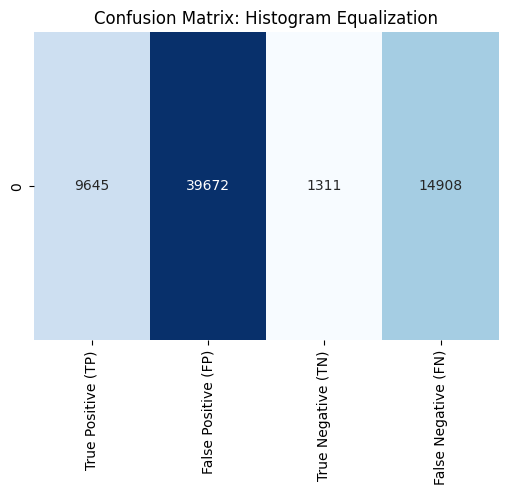


Confusion Matrix: Gamma Correction


,True Positive (TP),False Positive (FP),True Negative (TN),False Negative (FN)
0,173,4,1,65358


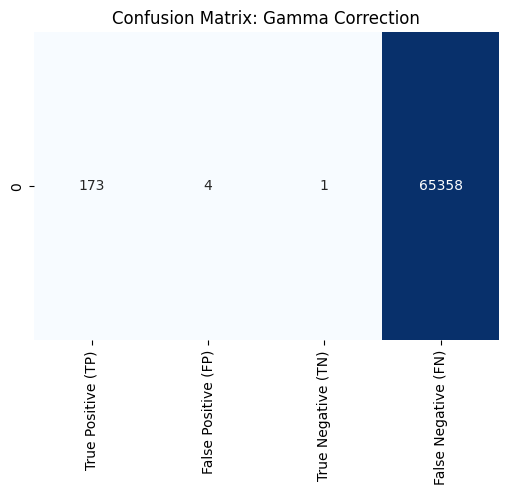


Confusion Matrix: Contrast Enhancement


,True Positive (TP),False Positive (FP),True Negative (TN),False Negative (FN)
0,1,0,0,65535


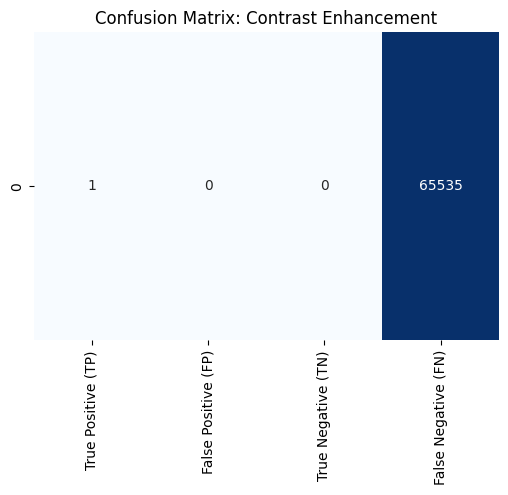

In [20]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_confusion_matrix(ground_truth, enhanced, threshold=10):
    """
    Calculate the confusion matrix for an enhanced image compared to the ground truth image.

    Args:
        ground_truth (np.array): The "good image" (reference image) in BGR format.
        enhanced (np.array): The enhanced image in BGR format.
        threshold (int): The tolerance for pixel intensity differences.

    Returns:
        dict: Confusion matrix containing TP, FP, TN, FN counts.
    """
    # Resize images to ensure they have the same dimensions
    ground_truth = cv2.resize(ground_truth, (256, 256))
    enhanced = cv2.resize(enhanced, (256, 256))

    # Convert images to grayscale for intensity comparison
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Initialize confusion matrix components
    TP = FP = TN = FN = 0

    # Compare pixel intensities
    for gt_pixel, en_pixel in zip(ground_truth_gray.flatten(), enhanced_gray.flatten()):
        diff = abs(gt_pixel - en_pixel)
        if diff <= threshold:  # Within acceptable range, considered a match
            if en_pixel == gt_pixel:  # No enhancement needed
                TN += 1
            else:  # Enhanced correctly
                TP += 1
        else:
            if en_pixel > gt_pixel:  # Over-enhanced
                FP += 1
            else:  # Under-enhanced
                FN += 1

    # Create the confusion matrix
    confusion_matrix = {
        "True Positive (TP)": TP,
        "False Positive (FP)": FP,
        "True Negative (TN)": TN,
        "False Negative (FN)": FN
    }

    return confusion_matrix

def display_confusion_matrix_as_table(conf_matrix, title):
    """
    Display the confusion matrix as a table using pandas DataFrame.

    Args:
        conf_matrix (dict): Confusion matrix as a dictionary.
        title (str): Title of the table.
    """
    # Convert dictionary to DataFrame
    df = pd.DataFrame([conf_matrix])

    # Display the table
    print(f"\n{title}")
    display(df)

    # Plot a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.show()


# Load the images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Apply the enhancement methods
hist_eq_img = histogram_equalization(ori_img)
gamma_img = gamma_correction(ori_img, gamma=2)
high_contrast_img = increase_contrast(ori_img)

# Calculate confusion matrices
hist_eq_conf_matrix = calculate_confusion_matrix(good_img, hist_eq_img)
gamma_conf_matrix = calculate_confusion_matrix(good_img, gamma_img)
contrast_conf_matrix = calculate_confusion_matrix(good_img, high_contrast_img)

# Display confusion matrices as tables
display_confusion_matrix_as_table(hist_eq_conf_matrix, "Confusion Matrix: Histogram Equalization")
display_confusion_matrix_as_table(gamma_conf_matrix, "Confusion Matrix: Gamma Correction")
display_confusion_matrix_as_table(contrast_conf_matrix, "Confusion Matrix: Contrast Enhancement")


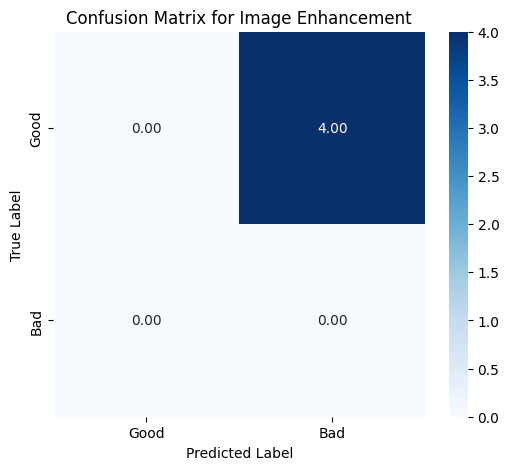

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Enhanced images
hist_eq_img = histogram_equalization(ori_img)
gamma_img = gamma_correction(ori_img, gamma=2)
high_contrast_img = increase_contrast(ori_img)

# Function to compute SSIM
def calculate_ssim(ref, img):
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return ssim(ref_gray, img_gray)

# Function to compute PSNR
def calculate_psnr(ref, img):
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Classify based on SSIM and PSNR thresholds
def classify_image(ref, img):
    ssim_score = calculate_ssim(ref, img)
    psnr_score = calculate_psnr(ref, img)
    if ssim_score > 0.85 and psnr_score > 30:
        return "Good"
    else:
        return "Bad"

# Generate labels
true_labels = ["Good", "Good", "Good", "Good"]
pred_labels = [
    classify_image(good_img, ori_img),
    classify_image(good_img, hist_eq_img),
    classify_image(good_img, gamma_img),
    classify_image(good_img, high_contrast_img)
]

# Compute confusion matrix
labels = ["Good", "Bad"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Image Enhancement")
plt.show()


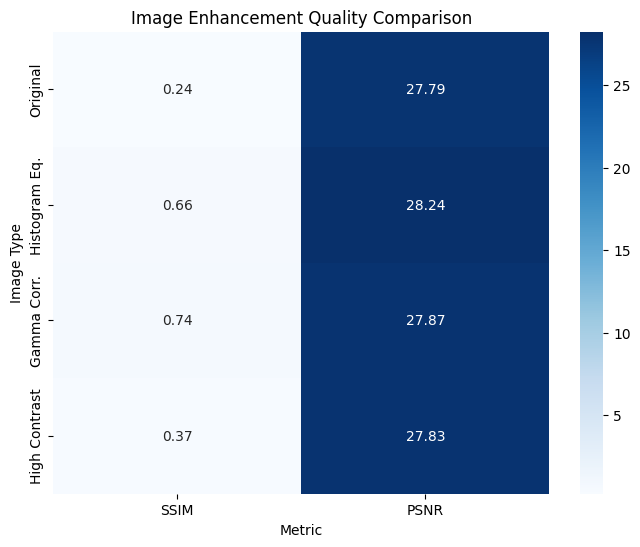

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

# Load images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Enhanced images
hist_eq_img = histogram_equalization(ori_img)
gamma_img = gamma_correction(ori_img, gamma=2)
high_contrast_img = increase_contrast(ori_img)

# Function to compute SSIM
def calculate_ssim(ref, img):
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return ssim(ref_gray, img_gray)

# Function to compute PSNR
def calculate_psnr(ref, img):
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Compute SSIM and PSNR values
methods = ["Original", "Histogram Eq.", "Gamma Corr.", "High Contrast"]
ssim_values = [
    calculate_ssim(good_img, ori_img),
    calculate_ssim(good_img, hist_eq_img),
    calculate_ssim(good_img, gamma_img),
    calculate_ssim(good_img, high_contrast_img)
]
psnr_values = [
    calculate_psnr(good_img, ori_img),
    calculate_psnr(good_img, hist_eq_img),
    calculate_psnr(good_img, gamma_img),
    calculate_psnr(good_img, high_contrast_img)
]

# Create a matrix-like table with SSIM and PSNR values
confusion_matrix_data = np.array([
    [ssim_values[0], psnr_values[0]],
    [ssim_values[1], psnr_values[1]],
    [ssim_values[2], psnr_values[2]],
    [ssim_values[3], psnr_values[3]]
])

# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["SSIM", "PSNR"], yticklabels=methods)
plt.xlabel("Metric")
plt.ylabel("Image Type")
plt.title("Image Enhancement Quality Comparison")
plt.show()


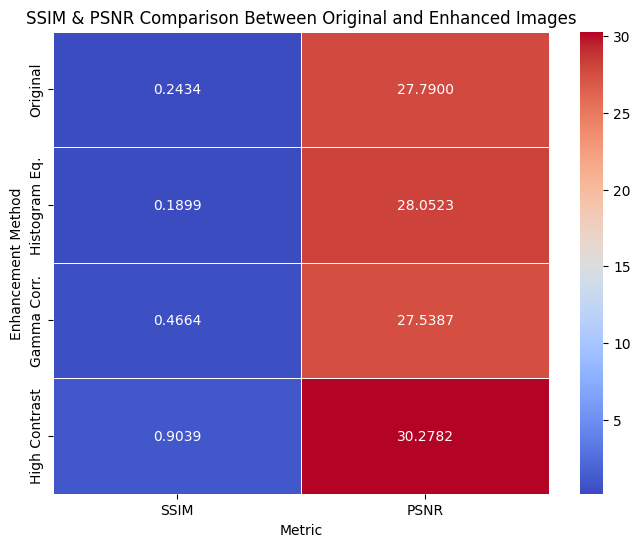

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

# Define functions for enhancement
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def gamma_correction(img, gamma=2.0):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def increase_contrast(img, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# Load images
original_img = cv2.imread('lowLightImage.png')  # Original reference image
good_img = cv2.imread('goodImage.png')  # Ideal enhanced image (ground truth)

# Generate enhanced images
hist_eq_img = histogram_equalization(original_img)
gamma_img = gamma_correction(original_img, gamma=2.0)
high_contrast_img = increase_contrast(original_img, alpha=1.5)

# Function to compute SSIM
def calculate_ssim(ref, img):
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return ssim(ref_gray, img_gray)

# Function to compute PSNR
def calculate_psnr(ref, img):
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Compare original with enhanced versions
methods = ["Original", "Histogram Eq.", "Gamma Corr.", "High Contrast"]
ssim_values = [
    calculate_ssim(original_img, good_img),
    calculate_ssim(original_img, hist_eq_img),
    calculate_ssim(original_img, gamma_img),
    calculate_ssim(original_img, high_contrast_img)
]
psnr_values = [
    calculate_psnr(original_img, good_img),
    calculate_psnr(original_img, hist_eq_img),
    calculate_psnr(original_img, gamma_img),
    calculate_psnr(original_img, high_contrast_img)
]

# Create a matrix-like table with SSIM and PSNR values
comparison_data = np.array([
    [ssim_values[0], psnr_values[0]],
    [ssim_values[1], psnr_values[1]],
    [ssim_values[2], psnr_values[2]],
    [ssim_values[3], psnr_values[3]]
])

# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(comparison_data, annot=True, fmt=".4f", cmap="coolwarm",
            xticklabels=["SSIM", "PSNR"], yticklabels=methods, linewidths=0.5)
plt.xlabel("Metric")
plt.ylabel("Enhancement Method")
plt.title("SSIM & PSNR Comparison Between Original and Enhanced Images")
plt.show()


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

# Load images
good_img = cv2.imread('goodImage.png')
ori_img = cv2.imread('lowLightImage.png')

# Check if images are loaded properly
if good_img is None or ori_img is None:
    raise ValueError("Error: One or both images not loaded properly.")

# Resize good_img to match ori_img if needed
if good_img.shape != ori_img.shape:
    good_img = cv2.resize(good_img, (ori_img.shape[1], ori_img.shape[0]))

# Convert images to grayscale
good_gray = cv2.cvtColor(good_img, cv2.COLOR_BGR2GRAY)
ori_gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)

# Function to compute SSIM
def calculate_ssim(ref, img):
    return ssim(ref, img)

# Function to compute PSNR
def calculate_psnr(ref, img):
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Compute SSIM and PSNR values
ssim_good_vs_ori = calculate_ssim(good_gray, ori_gray)
psnr_good_vs_ori = calculate_psnr(good_gray, ori_gray)

print(f"SSIM (Good vs Original): {ssim_good_vs_ori:.4f}")
print(f"PSNR (Good vs Original): {psnr_good_vs_ori:.2f} dB")

SSIM (Good vs Original): 0.2434
PSNR (Good vs Original): 27.55 dB
